In [63]:
import pandas as pd
import numpy as np
import sklearn.decomposition
import os
import matplotlib.pyplot as plt
import seaborn as sns 
# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)


In [2]:
genmap = pd.read_csv('../input/library_genotype_mapping.txt', comment='#')
genmap.genotype = genmap.genotype.apply(str)
genmap.genotype = genmap.genotype.apply(str.lower) # make sure everything is always in lowercase


In [3]:
# Make all possible combinations of WT, X
combs = []
for gene in genmap.genotype.unique():
    if gene != 'wt':
        combs += [['WT', gene]]

In [8]:
# get all pandas tpm dataframes for each project
# tpm files are in kallisto_loc
kallisto_loc = '../input/kallisto_all/'

tpm = {}  # initialize an empty hash

# get tpm for each project
for prjct in genmap.project_name.unique():
    tpm[prjct] = pd.read_csv(kallisto_loc + prjct +'/kallisto/abundance.tsv', sep='\t')

In [16]:
# load all the beta values for each genotype:
sleuth_loc = '../sleuth/'

beta = {}  # empty hash

# get betas for each genotype comparison:
for comb in combs:
    c = comb[0] + '_' + comb[1]
    beta[comb[1]] = pd.read_csv(sleuth_loc + c + '/betas.csv')

In [53]:
# PCA prep

# to perform PCA, first place all the tpm columns into a single matrix. 
# array = np.array(tpm[genmap.project_name.unique()[0]])
array = np.array([])
for prjct in genmap.project_name.unique():
    x = tpm[prjct].tpm.values
    if len(array) == 0:
        array = np.array(x)
    else:
        array = np.vstack((array, x))

# array should be (sample, genes) dimensions.



In [99]:
# PCA
sklearn_pca = sklearn.decomposition.PCA()
sklearn_pca.fit(array)
where = np.max(np.where(np.cumsum(sklearn_pca.explained_variance_ratio_) < 0.9))
print('The first {} principal components explain >=90% of the data'.format(where))

The first 4 principal components explain >=90% of the data


In [97]:
# Perform the PCA again retaining only the top 'where' components
sklearn_pca = sklearn.decomposition.PCA(n_components=where)
sklearn_pca.fit(array)

# Project the data into this 'where'D space and convert it back to a tidy dataframe
cols = []
for i in np.arange(1, where+1):
    cols += ['PCA{0}'.format(i)]

df_2D = pd.DataFrame(sklearn_pca.transform(array),
                     columns=cols)
# add a sample and genotype column
df_2D['samples'] = genmap.project_name.unique()
l = lambda x: genmap[genmap.project_name == x].genotype.values[0]
df_2D['genotypes'] = df_2D.samples.apply(l)
df_2D.head()

,PCA1,PCA2,PCA3,PCA4,samples,genotypes
0,-7597.070087,-2748.583552,-3246.871740,1290.455581,Project_17434_indexN704-N517,wt
1,11507.253519,-2051.481912,-1497.092629,-3054.503202,Project_17441_indexN704-N508,a
2,-3499.905323,5120.560035,-2885.212424,3672.694861,Project_17448_indexN705-N507,d
3,-7673.426882,-2525.724491,-1947.520648,5304.474756,Project_17435_indexN704-N502,wt
4,10090.924838,-3448.230513,-2854.242845,-456.802389,Project_17442_indexN705-N517,a


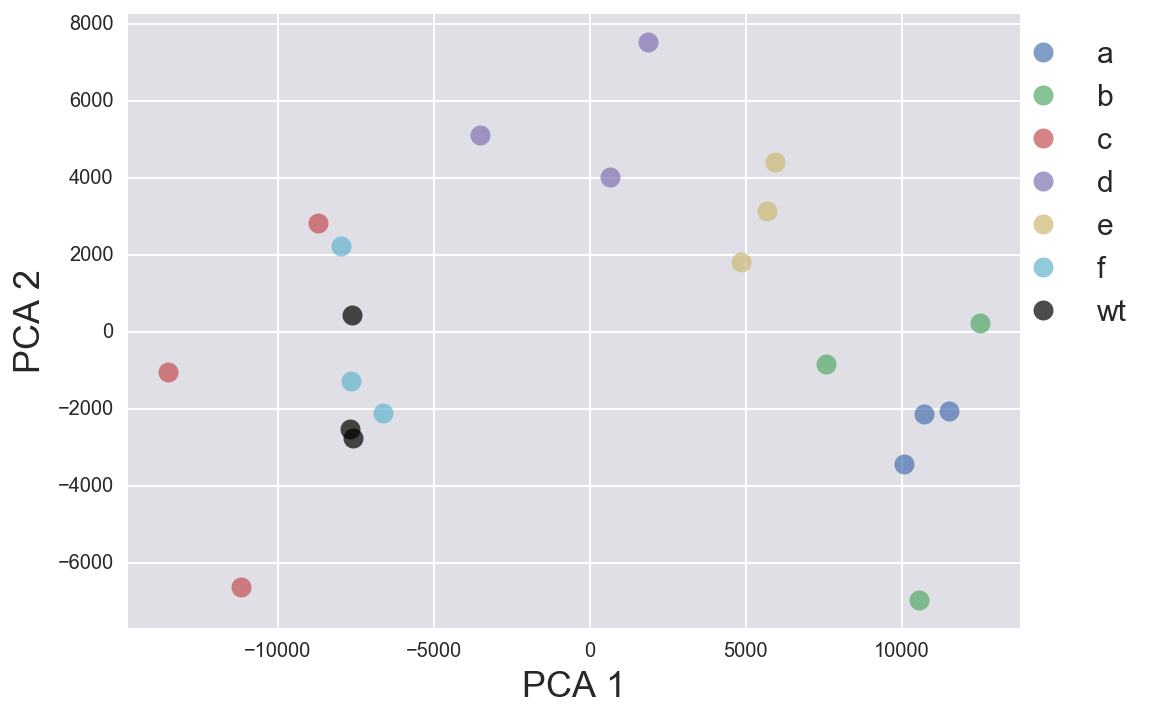

In [98]:
# plot first 2d components! 
for key, group in df_2D.groupby(['genotypes']):
    if key == 'wt':
        plt.plot(group.PCA1, group.PCA2, 'ko', alpha=0.7, label=key, ms=10)
    else:
        plt.plot(group.PCA1, group.PCA2, 'o', alpha=0.7, label=key, ms=10)

# Tidy up plot
plt.legend(bbox_to_anchor=(1.15, 1), fontsize=15)
plt.margins(0.05)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.savefig('../output/preliminary_pca.pdf')

In [101]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(linkage='average',
                                connectivity=None,
                                n_clusters=2)
model.fit(sklearn_pca.transform(array))



AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average',
            memory=Memory(cachedir=None), n_clusters=2, n_components=None,
            pooling_func=<function mean at 0x1071dae18>)

In [86]:
x

range(1, 10)